In [16]:
import sys
#sys.path.insert(0, dir_notebook)

from my_units import *
from functions_model import * 
from functions_load import *
from functions_yellin import *
from functions_likelihood import *

i_mock_str = '6'
i_m_str = '88'

i_mock = int(i_mock_str) # mock file number
i_m = int(i_m_str) # axion mass integer
print('i_mock =',str(i_mock),'| i_m =',str(i_m))

i_mock = 6 | i_m = 88


In [17]:
dir_home = '/mnt/home/kvantilburg/'
dir_ceph = dir_home+'ceph/luminous-basin/'
dir_events = dir_ceph+'mocks/event_lists/'
dir_source = dir_ceph+'data/products_80610202001_orbit1_chu12_spatialARF/'
dir_production = dir_ceph+'data/production/'
dir_background = dir_home+'/luminous-basin/data/backgrounds/'
dir_res = dir_ceph+'results/mocks/mock_'+str(i_mock)+'/'
dir_mcmc = dir_res+'mcmc/'

dir_proj = dir_ceph+'results/mocks/mock_'+str(i_mock)+'/proj/'

file_rho0 = dir_proj+'rho0_'+str(i_mock)+'_'+str(i_m)+'_fid.csv'
file_proj = dir_proj+'proj_'+str(i_mock)+'_'+str(i_m)+'_fid.csv'

# time intervals [seconds]
good_time_ints = np.asarray([
    [3.37603341e+08, 3.376033795e+08],
    [3.376036305e+08, 3.3760522972e+08]
])
exposure = np.sum([interval[1]-interval[0] for interval in good_time_ints])
livetime = np.asarray([1501.16599845754, 1481.86081041239])/exposure # effective fractional livetime of A and B
duration = np.max(good_time_ints)- np.min(good_time_ints)
# time bins
N_bins_t = 10
bins_t = np.linspace(good_time_ints[0][0], good_time_ints[-1][1], N_bins_t+1)

# energy bins [units = keV]
sigma_E = 0.166 # energy resolution [keV]
n_sigma_E = 3
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)
list_m = np.arange(3,40,0.1)
m = list_m[i_m]  # axion mass [keV]

# fiducial solar position 
ra_sun_fid = 170.66855149 * degree
dec_sun_fid = 4.02092024 * degree
# error on solar position 
sigma_sun = 2 * arcmin
# shift in solar position over duration starting from t_min
delta_ra_sun = 0.01962028 * degree
delta_dec_sun = -0.00835105 * degree
t_min = 3.37603341e+08
sigma_sun = 2*arcmin # error on solar position

# initial solar position
ra_sun_0 = ra_sun_fid
dec_sun_0 = dec_sun_fid

list_file_events = np.sort([dir_events+file for file in listdir(dir_events) if file[0:len(str(i_mock))+1]==str(i_mock)+'_'])
file_box_centers = dir_source+'box_centers.txt'
list_file_arf = [dir_source+'arfs/'+file for file in listdir(dir_source+'arfs/')]

In [18]:
##### load data #####
print('m = '+str(m)[0:8]+': initialized, loading data...')

df_data = load_data(m,sigma_E,good_time_ints,livetime,bins_t,bins_E,n_sigma_E,list_file_events,file_box_centers,list_file_arf)
t = df_data['t'].to_numpy()
E = df_data['E'].to_numpy()
ra = df_data['ra'].to_numpy()
dec = df_data['dec'].to_numpy()
exp = df_data['exp'].to_numpy()
arf = df_data['arf'].to_numpy()
eps = exp * arf * (df_data['Omega'].to_numpy() * arcmin**2 / (degree**2)) * width_E
counts = df_data['counts'].to_numpy()
df_data

m = 11.80000: initialized, loading data...


,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,96,-6,-6,3.376033e+08,5.44,170.889,3.75981,35.289849,93.826469,1.0,0
1,A,0,96,-6,-5,3.376033e+08,5.44,170.881,3.77425,35.289849,68.457832,1.0,0
2,A,0,96,-6,-4,3.376033e+08,5.44,170.872,3.78868,35.289849,113.434158,1.0,0
3,A,0,96,-6,-3,3.376033e+08,5.44,170.864,3.80311,35.289849,111.650574,1.0,0
4,A,0,96,-6,-2,3.376033e+08,5.44,170.856,3.81755,35.289849,195.422913,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81115,B,9,119,6,2,3.376050e+08,6.36,171.009,3.97187,170.897354,121.601250,1.0,0
81116,B,9,119,6,3,3.376050e+08,6.36,171.001,3.98630,170.897354,99.626968,1.0,0
81117,B,9,119,6,4,3.376050e+08,6.36,170.992,4.00073,170.897354,71.892075,1.0,0
81118,B,9,119,6,5,3.376050e+08,6.36,170.984,4.01517,170.897354,70.418320,1.0,0


In [19]:
df_data_not_m = load_data_not_m(m,sigma_E,good_time_ints,livetime,bins_t,bins_E,n_sigma_E,list_file_events,file_box_centers,list_file_arf)
E_not_m = df_data_not_m['E'].to_numpy()
exp_not_m = df_data_not_m['exp'].to_numpy()
counts_not_m = df_data_not_m['counts'].to_numpy()
df_data_not_m

,detector,idx_E,E,exp,counts
35,A,35,3.00,1501.165998,61
36,A,36,3.04,1501.165998,63
37,A,37,3.08,1501.165998,57
38,A,38,3.12,1501.165998,60
39,A,39,3.16,1501.165998,55
...,...,...,...,...,...
9917,B,4956,199.84,1481.860810,0
9918,B,4957,199.88,1481.860810,0
9919,B,4958,199.92,1481.860810,0
9920,B,4959,199.96,1481.860810,0


In [20]:
df_tmp1 = pd.read_csv(file_rho0)
N_data = len(pd.read_csv(file_proj))
N_sig_lim_poisson = poisson_limit(N_data)
S_0_lim_poisson = N_sig_lim_poisson/df_tmp1['rho_0'][0]
S0_guess = S_0_lim_poisson
print('S0_guess = '+str(S0_guess)+' sec^{-1} degree^{-2} cm^{-2}')

S0_guess = 0.21248776547139933 sec^{-1} degree^{-2} cm^{-2}


In [21]:
df_background = pd.read_csv(dir_background+'backgrounds.txt',delimiter=" ",skiprows=3,header=None)
df_background.columns = ["Energy [keV]","unknown","Total", "aCXB", "Internal","fXCB","Continuum"]
df_background

,Energy [keV],unknown,Total,aCXB,Internal,fXCB,Continuum
0,1.620000,0.020000,0.000185,3.594298e-05,1.808465e-06,0.000003,0.000144
1,1.660000,0.020000,0.000194,4.424206e-05,2.023978e-06,0.000003,0.000144
2,1.700000,0.020000,0.000204,5.304552e-05,2.230286e-06,0.000004,0.000145
3,1.740000,0.020000,0.000214,6.219269e-05,2.424499e-06,0.000004,0.000145
4,1.780000,0.020000,0.000225,7.193359e-05,2.609324e-06,0.000005,0.000145
...,...,...,...,...,...,...,...
4091,165.260010,0.019997,0.000229,2.040408e-08,9.147808e-08,0.000000,0.000229
4092,165.300003,0.020004,0.000229,1.926954e-08,8.636118e-08,0.000000,0.000229
4093,165.339996,0.019997,0.000229,1.805362e-08,8.088239e-08,0.000000,0.000229
4094,165.380005,0.019997,0.000229,1.691932e-08,7.578295e-08,0.000000,0.000229


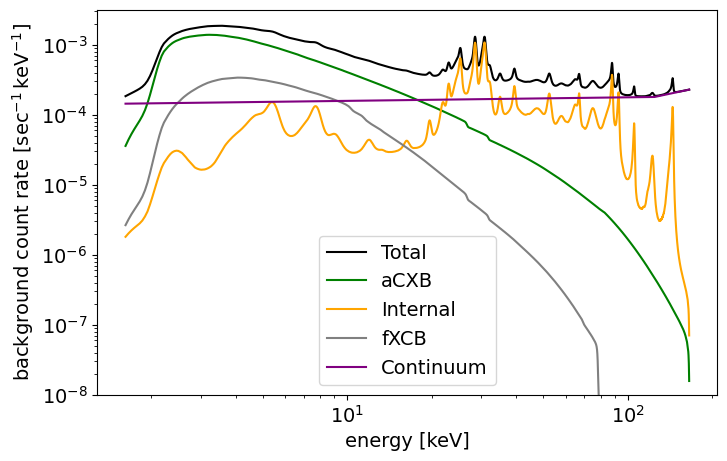

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['Total'].to_numpy(),label='Total',color=(0,0,0))
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['aCXB'].to_numpy(),label='aCXB',color='green')
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['Internal'].to_numpy(),label='Internal',color='orange')
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['fXCB'].to_numpy(),label='fXCB',color='gray')
ax.plot(df_background['Energy [keV]'].to_numpy(),df_background['Continuum'].to_numpy(),label='Continuum',color='purple')
#plt.plot(df_background['Energy [keV]'].to_numpy(dtype=float),df_background['unknown'].to_numpy(dtype=float),label='unknown')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10**(-8),10**(-2.5))
ax.set_xlabel('energy [keV]')
ax.set_ylabel('background count rate [$\mathrm{sec^{-1} \, keV^{-1}}$]')
ax.legend();

In [23]:
E_bg = df_background['Energy [keV]'].to_numpy()
rate_total_bg = df_background['Total'].to_numpy()
rate_aCXB_bg = df_background['aCXB'].to_numpy()
rate_internal_bg = df_background['Internal'].to_numpy()
rate_fXCB_bg = df_background['fXCB'].to_numpy()
rate_continuum_bg = df_background['Continuum'].to_numpy()

int_rate_total_bg = interp1d(E_bg,rate_total_bg, fill_value='extrapolate')
int_rate_aCXB_bg = interp1d(E_bg, rate_aCXB_bg, fill_value='extrapolate')
int_rate_internal_bg = interp1d(E_bg, rate_internal_bg, fill_value='extrapolate')
int_rate_continuum_bg = interp1d(E_bg, rate_continuum_bg, fill_value='extrapolate')

# MCMC

In [42]:
# Background guesses from global fit:
B1_guess = 30.73054844
B2_guess = 26.84442745
B3_guess = 20.16336952
B1_sigma = 2.2184273926203124
B2_sigma = 2.6849045247214165
B3_sigma = 2.947270654559794

p0_init = np.asarray([[B1_guess, B2_guess, B3_guess, S0_guess, ra_sun_fid, dec_sun_fid]])

In [43]:
nwalkers = 32
ndim = 6 # B1,B2,B3,S0,alpha0,delta0
p0_B1 = np.abs(np.random.normal(B1_guess,B1_sigma,nwalkers))
p0_B2 = np.abs(np.random.normal(B2_guess,B2_sigma,nwalkers))
p0_B3 = np.abs(np.random.normal(B3_guess,B3_sigma,nwalkers))
p0_S0 = np.random.normal(S0_guess,0.1*S0_guess,nwalkers)
p0_ra_sun_0 = np.random.normal(ra_sun_fid,sigma_sun,nwalkers)
p0_dec_sun_0 = np.random.normal(dec_sun_fid,sigma_sun,nwalkers)
p0 = np.transpose([p0_B1,p0_B2,p0_B3,p0_S0,p0_ra_sun_0,p0_dec_sun_0])

In [44]:
# Set up the backend
# Don't forget to clear it in case the file already exists
file_mcmc = dir_mcmc+'samples_'+str(i_mock)+'_'+str(i_m)+'_nb.h5'
backend = emcee.backends.HDFBackend(file_mcmc)
backend.reset(nwalkers, ndim)

In [45]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, LL, backend=backend,
                                   args=[m,t,E,ra,dec,exp,eps,counts,exposure,width_E,sigma_E,
                                      t_min,delta_ra_sun,delta_dec_sun,sigma_sun,ra_sun_fid,dec_sun_fid,duration,
                                      E_not_m,exp_not_m,counts_not_m,
                                      int_rate_aCXB_bg,int_rate_internal_bg,int_rate_continuum_bg])

In [46]:
max_n = int(2e4)
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

100%|██████████| 20000/20000 [6:54:22<00:00,  1.24s/it]  


_____

In [86]:
# if reading in from file
reader = emcee.backends.HDFBackend(file_mcmc)

tau = reader.get_autocorr_time(tol=0)
burnin = int(4 * np.max(tau))
thin = int(0.1 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))

burn-in: 3382
thin: 11
flat chain shape: (48320, 6)


In [48]:
p_out = np.asarray([np.percentile(samples[:,i],[1,16,50,84,99]) for i in range(np.shape(samples)[1])])

In [49]:
[B1_fit, B2_fit, B3_fit, S0_fit, ra_sun_fit, dec_sun_fit] = p_out[:,2]
print([B1_guess, B2_guess, B3_guess, S0_guess, ra_sun_fid, dec_sun_fid])
print([B1_fit, B2_fit, B3_fit, S0_fit, ra_sun_fit, dec_sun_fit])

[30.73054844, 26.84442745, 20.16336952, 0.21248776547139933, 2.9787281531099743, 0.07017829714808059]
[65.77949474181642, 19.455172619742058, 8.779942244296059, 0.20726844374757186, 2.978711841920598, 0.07025181578778378]


## Plots

### MCMC convergence

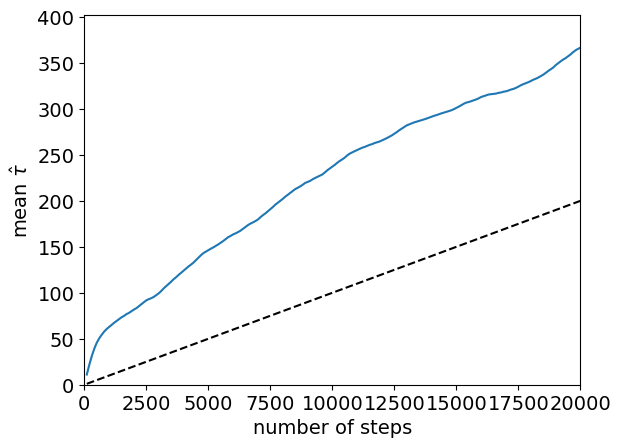

In [50]:
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [98]:
samples_w = sampler.get_chain(discard=0)

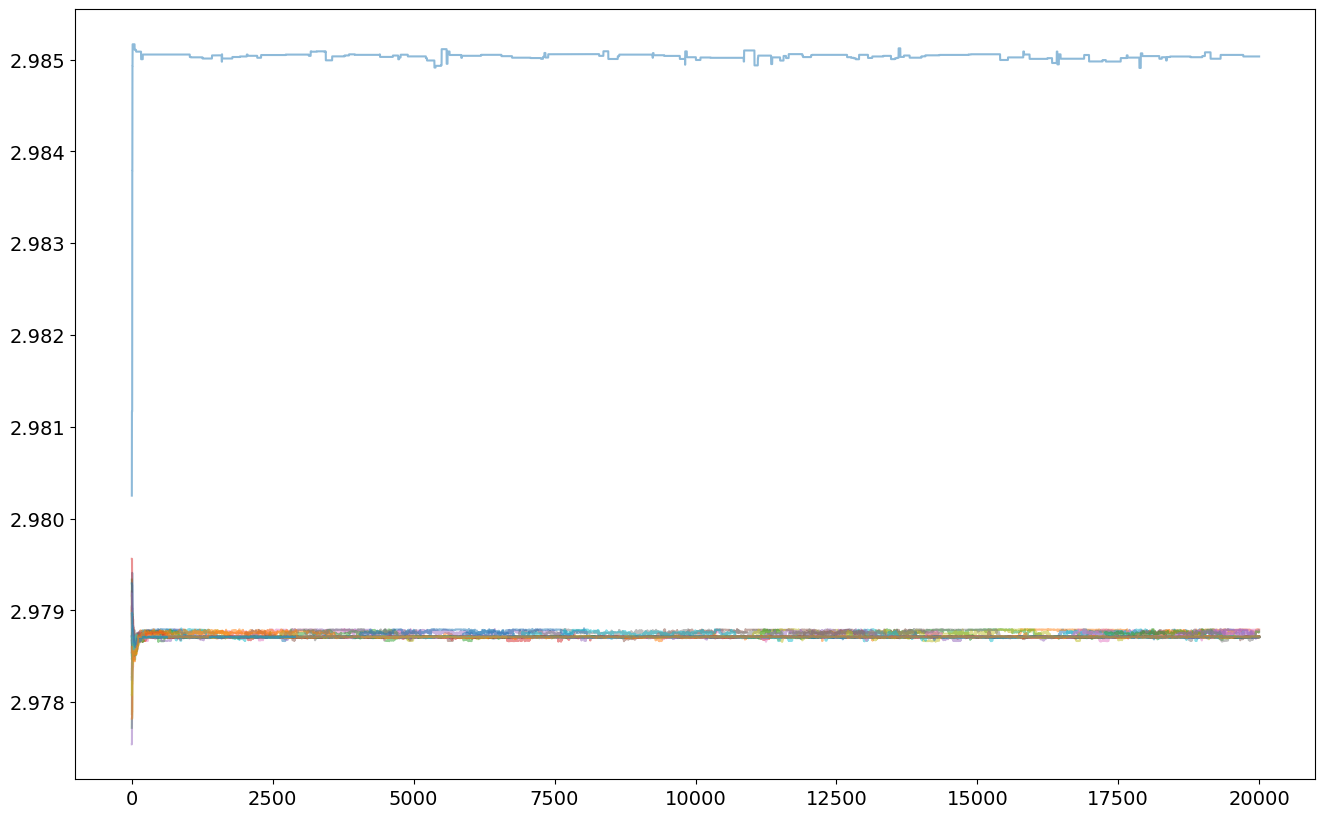

In [105]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
#for i in range(np.shape(samples_w)[1]):
for i in range(nwalkers):
    ax.plot(samples_w[:,i,4],alpha=0.5)

### Corner

In [87]:
units = np.asarray([1,1,1,1e4,180/np.pi,180/np.pi])
samples_units = np.transpose(np.diag(units) @ np.transpose(samples))
p_out_units = np.asarray([np.percentile(samples_units[:,i],[1,16,50,84,99]) for i in range(np.shape(samples_units)[1])])

In [88]:
print('fiducial solar position = ['+str((ra_sun_fid * units[4], dec_sun_fid * units[5]))+' +/- '+ str(sigma_sun * units[4])[:5]+'] deg')

fiducial solar position = [(170.66855149, 4.02092024) +/- 0.033] deg


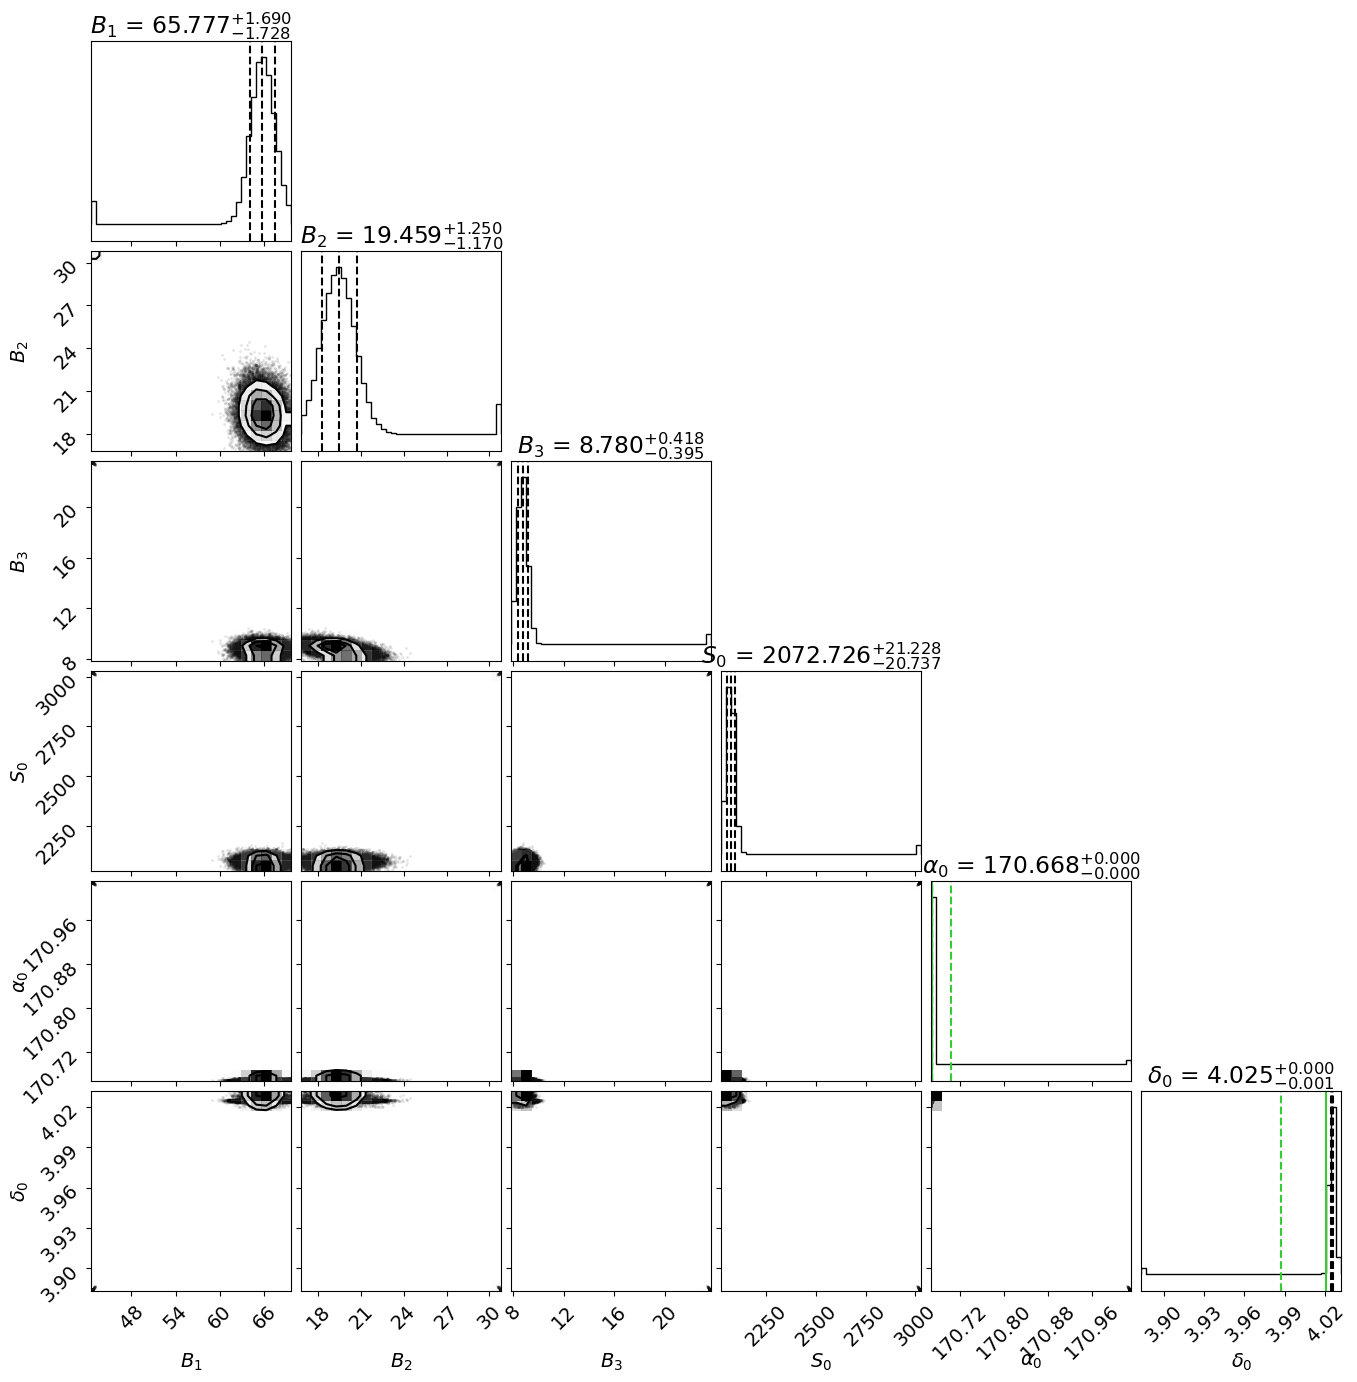

In [89]:
labels = [r'$B_1$',r'$B_2$',r'$B_3$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
fig = corner.corner(samples_units[:],
              labels=labels,show_titles=True,title_fmt='.3f',
              scale_hist=True,hist_bin_factor=2,range=p_out_units[:,[0,-1]],
              top_ticks=False,quantiles=[0.16,0.5,0.84],verbose=False);
# Extract the axes
ax = np.array(fig.axes).reshape((ndim, ndim))
ax[4,4].axvline(ra_sun_fid * units[4],color=(0.2,0.8,0.2));
ax[4,4].axvline((ra_sun_fid + sigma_sun) * units[4],color=(0.2,0.8,0.2),ls='dashed');
ax[4,4].axvline((ra_sun_fid - sigma_sun) * units[4],color=(0.2,0.8,0.2),ls='dashed');
ax[5,5].axvline(dec_sun_fid * units[5],color=(0.2,0.8,0.2));
ax[5,5].axvline((dec_sun_fid + sigma_sun) * units[5],color=(0.2,0.8,0.2),ls='dashed');
ax[5,5].axvline((dec_sun_fid - sigma_sun) * units[5],color=(0.2,0.8,0.2),ls='dashed');

### Spectra

In [56]:
counts_sig = S0_fit * eps * T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration)*np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)

In [57]:
E_bin_size_1 = 0.04;
bins_E_hist_0 = np.logspace(np.log10(3),np.log10(200),150)
bins_E_hist_1 = np.arange(1.98-E_bin_size_1,220+E_bin_size_1,E_bin_size_1)

counts_hist_B1_0 = B1_fit * int_rate_aCXB_bg(bins_E_hist_0[:-1]) * exposure * (bins_E_hist_0[1:] - bins_E_hist_0[:-1])
counts_hist_B2_0 = B2_fit * int_rate_internal_bg(bins_E_hist_0[:-1]) * exposure * (bins_E_hist_0[1:] - bins_E_hist_0[:-1])
counts_hist_B3_0 = B3_fit * int_rate_continuum_bg(bins_E_hist_0[:-1]) * exposure * (bins_E_hist_0[1:] - bins_E_hist_0[:-1])

counts_hist_B1_1 = B1_fit * int_rate_aCXB_bg(bins_E_hist_1[:-1]) * exposure * (bins_E_hist_1[1:] - bins_E_hist_1[:-1])
counts_hist_B2_1 = B2_fit * int_rate_internal_bg(bins_E_hist_1[:-1]) * exposure * (bins_E_hist_1[1:] - bins_E_hist_1[:-1])
counts_hist_B3_1 = B3_fit * int_rate_continuum_bg(bins_E_hist_1[:-1]) * exposure * (bins_E_hist_1[1:] - bins_E_hist_1[:-1])

In [58]:
counts_hist_S0_0 = np.histogram(E,weights=counts_sig,bins=bins_E_hist_0)[0]
counts_hist_S0_1 = np.histogram(E,weights=counts_sig,bins=bins_E_hist_1)[0]

counts_hist_tot_0 = counts_hist_B1_0 + counts_hist_B2_0 + counts_hist_B3_0 + counts_hist_S0_0
counts_hist_tot_1 = counts_hist_B1_1 + counts_hist_B2_1 + counts_hist_B3_1 + counts_hist_S0_1

In [59]:
counts_hist_obs_m_0 = np.histogram(E,weights=counts,bins=bins_E_hist_0)[0]
counts_hist_obs_m_1 = np.histogram(E,weights=counts,bins=bins_E_hist_1)[0]
counts_hist_obs_not_m_0 = np.histogram(E_not_m,weights=counts_not_m,bins=bins_E_hist_0)[0]
counts_hist_obs_not_m_1 = np.histogram(E_not_m,weights=counts_not_m,bins=bins_E_hist_1)[0]

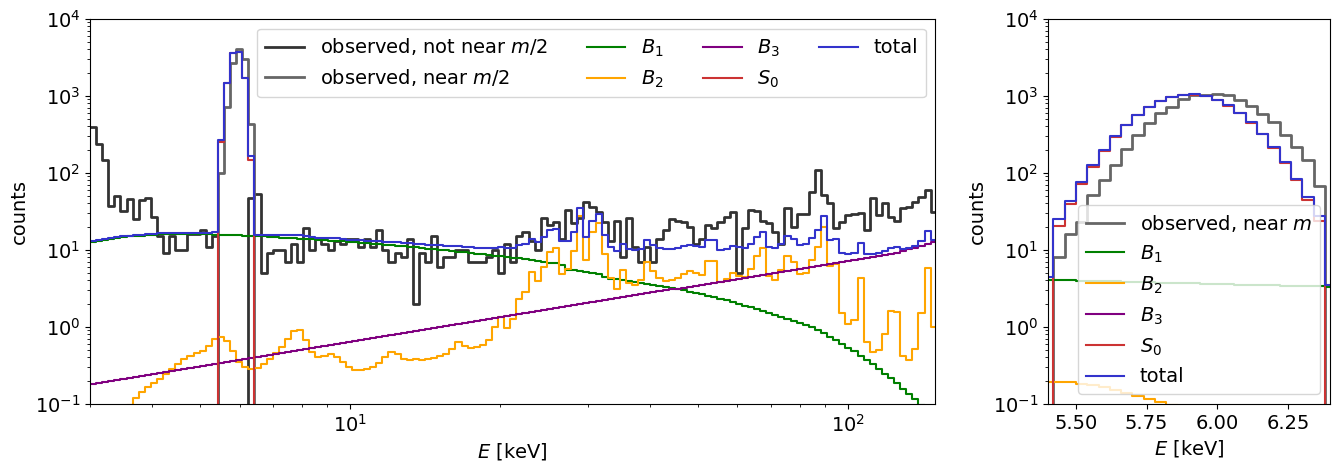

In [60]:
fig,ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[3,1]},figsize=(16,5))
#ax[0].hist(E_not_m,weights=counts_not_m,bins=bins_E_hist_0,histtype='step',color=(0.2,0.2,0.2),label=r'observed, not near $m/2$',lw=2);
#ax[0].hist(E,weights=counts,bins=bins_E_hist_0,histtype='step',color=(0.4,0.4,0.4),label=r'observed, near $m/2$',lw=2)
ax[0].step(bins_E_hist_0[:-1],counts_hist_obs_not_m_0,where='post',color=(0.2,0.2,0.2),label=r'observed, not near $m/2$',lw=2)
ax[0].step(bins_E_hist_0[:-1],counts_hist_obs_m_0,where='post',color=(0.4,0.4,0.4),label=r'observed, near $m/2$',lw=2)
ax[0].step(bins_E_hist_0[:-1],counts_hist_B1_0,where='post',color='green',label=r'$B_1$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_B2_0,where='post',color='orange',label=r'$B_2$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_B3_0,where='post',color='purple',label=r'$B_3$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_S0_0,where='post',color=(0.8,0.2,0.2),label=r'$S_0$')
ax[0].step(bins_E_hist_0[:-1],counts_hist_tot_0,where='post',color=(0.2,0.2,0.8),label='total')
#ax[0].hist(E,weights=counts_sig,bins=bins_E_hist_0,histtype='step',color=(0.8,0.2,0.2),label=r'$S_0$')
#ax[1].hist(E,weights=counts,bins=bins_E_hist_1,histtype='step',color=(0.4,0.4,0.4),label=r'observed, near $m$',lw=2)
ax[1].step(bins_E_hist_1[:-1],counts_hist_obs_m_1,where='post',color=(0.4,0.4,0.4),label=r'observed, near $m$',lw=2)
ax[1].step(bins_E_hist_1[:-1],counts_hist_B1_1,where='post',color='green',label=r'$B_1$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_B2_1,where='post',color='orange',label=r'$B_2$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_B3_1,where='post',color='purple',label=r'$B_3$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_S0_1,where='post',color=(0.8,0.2,0.2),label=r'$S_0$')
ax[1].step(bins_E_hist_1[:-1],counts_hist_tot_1,where='post',color=(0.2,0.2,0.8),label='total')
#ax[1].hist(E,weights=counts_sig,bins=bins_E_hist_1,histtype='step',color=(0.8,0.2,0.2),label=r'$S_0$')


ax[0].set_xlim(3,150)
ax[1].set_xlim(m/2-n_sigma_E*sigma_E,m/2+n_sigma_E*sigma_E)
ax[0].set_xscale('log'); ax[0].set_yscale('log'); 
ax[1].set_xscale('linear'); ax[1].set_yscale('log'); 
for i in range(2):
    ax[i].set_xlabel(r'$E~[\mathrm{keV}]$'); ax[i].set_ylabel(r'counts');
    ax[i].set_ylim(1e-1,1e4)
ax[0].legend(ncol=4,loc='upper right');
ax[1].legend(loc='lower right');

### Time dependence

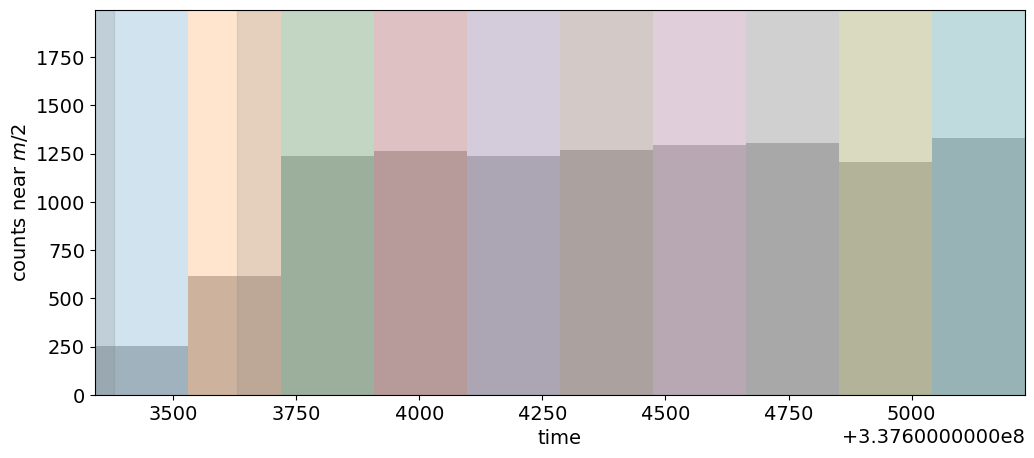

In [61]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
h = ax.hist(t,bins=bins_t,weights=counts,color=(0.4,0.4,0.4),alpha=0.4)
counts_ref = 1.5 * np.max(h[0])
for i in range(len(bins_t)-1):
    ax.fill_between(bins_t[i:i+2],counts_ref,alpha=0.2)
for i in range(len(good_time_ints)):
    ax.fill_between(good_time_ints[i],counts_ref,alpha=0.2,color=(0.5,0.5,0.5))
ax.set_ylim(0,counts_ref);
ax.set_xlim(bins_t[0],bins_t[-1]);
ax.set_ylabel(r'counts near $m/2$');
ax.set_xlabel(r'time');

## Limit

In [62]:
cdf_samples = stats.cumfreq(samples[:,3],numbins=10**6)

In [63]:
S0_cdf_array = cdf_samples.lowerlimit + np.linspace(0, cdf_samples.binsize*cdf_samples.cumcount.size,cdf_samples.cumcount.size)

In [64]:
cdf_S0_interpolation = interp1d(S0_cdf_array,cdf_samples.cumcount/samples_units.shape[0],bounds_error=False,fill_value=(1e-20,1))

In [65]:
def fun_intersect_unconstrained(S0,alpha=0.1):
    return (1-cdf_S0_interpolation(S0))-alpha

def fun_intersect_CLs(S0,alpha=0.1):
    return (1-cdf_S0_interpolation(S0))/(1-cdf_S0_interpolation(0))-alpha

In [66]:
S0_lim_unconstrained = optimize.brentq(fun_intersect_unconstrained,S0_cdf_array[0],S0_cdf_array[-1])
S0_lim_CLs = optimize.brentq(fun_intersect_unconstrained,S0_cdf_array[0],S0_cdf_array[-1])

NameError: name 'df_results' is not defined

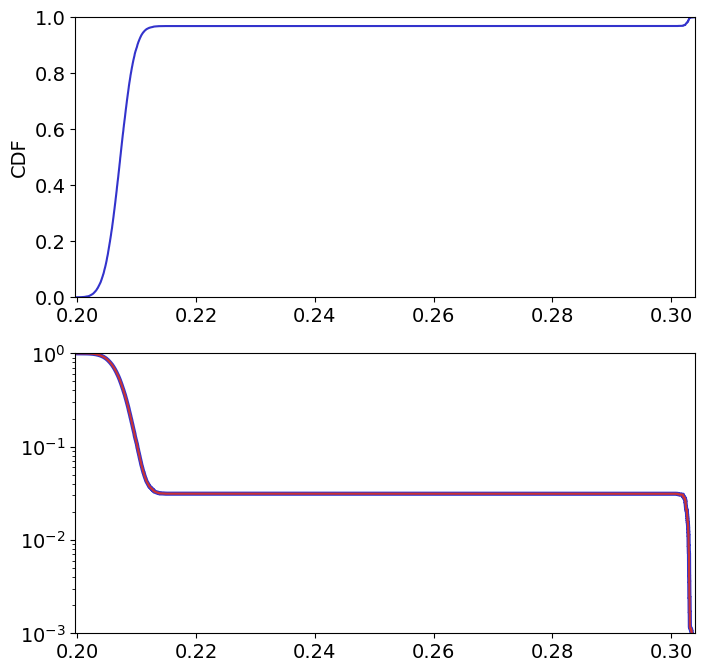

In [67]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
ax[0].set_xlim(S0_cdf_array[0],S0_cdf_array[-1])
ax[0].set_ylim(0,1);
ax[0].plot(S0_cdf_array,cdf_S0_interpolation(S0_cdf_array),color=(0.2,0.2,0.8))
ax[0].set_ylabel('CDF');
ax[1].set_xlim(S0_cdf_array[0],S0_cdf_array[-1])
ax[1].set_ylim(1e-3,1); ax[1].set_yscale('log')
h0, = ax[1].plot(S0_cdf_array,1-cdf_S0_interpolation(S0_cdf_array),lw=3,color=(0.2,0.2,0.8))
h1, = ax[1].plot(S0_cdf_array,(1-cdf_S0_interpolation(S0_cdf_array))/(1-cdf_S0_interpolation(0)),lw=1.5,color=(0.8,0.2,0.2))
h2 = ax[1].axvline(df_results['S_0_lim_poisson'][idx_m],color=(0,0,0))
h3 = ax[1].axvline(df_results['S_0_lim_yellin'][idx_m],color='orange')
h4 = ax[1].axvline(S0_lim_unconstrained,ls='dashed',lw=2,color=(0.2,0.2,0.8))#,label=r'$S_0^{\text{lim,unconstrained}}$')
h5 = ax[1].axvline(S0_lim_CLs,ls='dashed',lw=1,color=(0.8,0.2,0.2))#label=r'$S_0^{\text{lim,CLs}}$')
ax[1].set_ylabel(r'$p$ value');
ax[1].set_xlabel(r'$S_0 ~[\mathrm{sec^{-1}\,deg^{-2}\,cm^{-2}}]$')
ax[1].legend([h0,h1,h2,h3,h4,h5],[r'$p(S_0) \equiv 1-\mathrm{CDF}(S_0)$',r'$\mathrm{CL_s}(S_0) \equiv \frac{p(S_0)}{p(0)}$',
                                  '$S_0^{\mathrm{lim,Poisson}}$','$S_0^{\mathrm{lim,Yellin}}$','$S_0^{\mathrm{lim,unconstrained}}$','$S_0^{\mathrm{lim,CLs}}$']);